In [20]:
! pip install astropy
! pip install matplotlib
! pip install numpy
! pip install scipy

No global/local python version has been set yet. Please set the global/local version by typing:
pyenv global 3.7.4
pyenv local 3.7.4
No global/local python version has been set yet. Please set the global/local version by typing:
pyenv global 3.7.4
pyenv local 3.7.4
No global/local python version has been set yet. Please set the global/local version by typing:
pyenv global 3.7.4
pyenv local 3.7.4
No global/local python version has been set yet. Please set the global/local version by typing:
pyenv global 3.7.4
pyenv local 3.7.4


In [21]:
import astropy.io.fits as fits
import matplotlib.pylab as plt
import matplotlib
import numpy as np
import matplotlib.colors as mcolors


In [25]:
class open_iag():
	"""
	Open data and store as class attributes

	inputs:
	-------
	group : int
			group identifier (0-10) to indicate which telluric spectra to load

	attributes:
	----------
	v           - array [npoint] wavenumber array (cm-1)
	solar_atlas - array [npoint] IAG telluric corrected solar atlas
	err_atlas   - array [npoint] 1 sigma error values for solar_atlas
	flag_atlas  - array [npoint] flag values for solar_atlas
	nspec       - int  number of spectra in group
	CD_H2O      - float  log_10 of H2O column density (median across all fits)
	CD_O2       - float  log_10 of O2 column density (median across all fits)
	stel_mod    - array [npoint] solar model used to make telluric spectrum shifted to rest frame (should match solar_atlas aside from negligible shift)
	res_med     - array [npoint] median of residuals
	iodine		- array [npoint] iodine template
	jd          - array [nspec] julian date of observation
	tau         - array [nspec] best fit H2O optical depth for spectrum
	airmass     - array [nspec] airmass of observation
	tel_spectra - array [nspec, npoint] telluric spectra

	Functions:
	----------
	plot_tel(scale=None)
			- plots all telluric spectra in one frame with option for color scale

	plot_stel(flag_level=None,plot_tel=False)
			- plots solar atlas with options to mark flagged points or to plot a telluric spectrum
	"""
	def __init__(self,group):
		"""
		load things
		"""
		self.group = group

		f = fits.open(data_path + 'telluric_spectra_%s.fits' %int(group))
		fsol = fits.open(data_path + 'iag_telfree_solaratlas.fits')

		self.nspec = f[0].header['NSPEC']
		self.CD_H2O = f[0].header['CD_H2O']
		self.CD_O2  = f[0].header['CD_O2']

		# Pull out v and accompanying spectra
		self.v = f[1].data['v']
		self.stel_mod = f[1].data['stel_mod']
		self.res_med = f[1].data['res_med']
		self.iodine = f[1].data['iodine']

		# pull out specnums
		specnums = []
		cols = f[1].columns
		for col in cols:
			if col.name.startswith('telluric'):
				specnums.append(col.name[9:])

		self.specnums = np.array(specnums,dtype='str')

		# Pull out tau, jd, airmass, telluric spectra
		self.tau, self.jd, self.airmass = np.zeros(self.nspec), np.zeros(self.nspec), np.zeros(self.nspec)
		self.tel_spectra = np.zeros((self.nspec,len(self.v)))
		for i,specnum in enumerate(specnums):
			self.tau[i]         = f[0].header['TAU_' +specnum]
			self.jd[i]          = f[0].header['JD_' + specnum]
			self.airmass[i]     = f[0].header['AMS_' + specnum]
			self.tel_spectra[i] = f[1].data['telluric_' + specnum]

		f.close()

		# STEL STUF
		self.solar_atlas = fsol[1].data['s']
		self.err_atlas   = fsol[1].data['err']
		self.flag_atlas  = fsol[1].data['flags']
		fsol.close()


	def plot_tel(self,scale=None):
		"""
		Plot telluric Spectra

		scale (optional) : None, ('O2', 'H2O')
			  scale indicates how you want to align the telluric spectra
			  O2 scales by airmass (oxygen lines will be overlapped onto same scale)
			  H2O scales by airmass and PWV (aka tau) so H2O lines are on same scale
			  None plots the telluric spectra without any scaling

		Note: Colors in rainbow order of airmass *tau, except for scale='O2' for which color indicates airmass

		"""
		fig, ax = plt.subplots(1, 1, figsize=(6,3))#,gridspec_kw={'height_ratios': [3, 1]})

		if scale == None:
			for i in range(self.nspec):
				i_color = np.where( i == np.argsort(self.airmass * self.tau))[0][0]
				ax.plot(self.v,self.tel_spectra[i],
					c=cmap(1.0*i_color/self.nspec))

		elif scale == 'O2':
			for i in range(self.nspec):
				i_color = np.where( i == np.argsort(self.airmass))[0][0]
				ax.plot(self.v,self.tel_spectra[i]**(1/self.airmass[i]),
					c=cmap(1.0*i_color/self.nspec))

		elif scale == 'H2O':
			for i in range(self.nspec):
				i_color = np.where( i == np.argsort(self.airmass * self.tau))[0][0]
				ax.plot(self.v, self.tel_spectra[i]**(1/(self.airmass[i]*self.tau[i])),
						c=cmap(1.0*i_color/self.nspec))

		ax.set_xlabel('Wavenumber (cm$^{-1}$)')
		ax.set_ylabel('Transmittance')
		ax.set_title('Group %s' %self.group)

		plt.subplots_adjust(bottom=0.2,left=0.18)
		ax.set_ylim(0,1.2)
		#ax.legend(loc='best')

		return ax


	def plot_stel(self,flag_level=None,plot_tel=False):
		"""
		Plot Telluric corrected Solar Atlas with 2sigma error bar

		inputs:
		-------
		flag_level (optional) : None, (float 0-4)
					 will mark points with a flag level greater than given value
		
		plot_tel (optional) : Boolean, default False
					Overlay telluric spectrum
		"""
		fig, ax = plt.subplots(1, 1, figsize=(6,3))
		ax.fill_between(self.v,self.solar_atlas - 2*self.err_atlas,self.solar_atlas + 2*self.err_atlas,facecolor='gray',label=r'2$\sigma$')
		ax.plot(self.v,self.solar_atlas,'k',lw=0.5,label='IAG Solar Atlas')

		ax.set_xlabel('Wavenumber (cm$^{-1}$)')
		ax.set_ylabel('Transmittance')
		plt.subplots_adjust(bottom=0.2,left=0.18)
		ax.set_ylim(0,1.2)

		if flag_level != None:
			imark = np.where(self.flag_atlas > flag_level)[0]
			if len(imark) == 0:
				pass
			else:
				ax.plot(self.v[imark],self.solar_atlas[imark],'m.',label='Flagged')

		if plot_tel:
			ax.plot(self.v,np.mean(self.tel_spectra,axis=0),c='steelblue',label='Mean Telluric')

		ax.legend(loc='best',fontsize=12)

	def plot_visible_spectrum(self, index=0, threshold=0.95):
		"""
		Affiche le spectre tellurique comme un spectre d'absorption :
		bande de couleur continue avec des raies sombres là où la transmittance est basse.
		
		inputs:
		-------
		index : int, index du spectre tellurique à afficher
		threshold : float (0-1), en dessous de cette valeur, une raie sombre est tracée
		"""
		import numpy as np
		import matplotlib.pyplot as plt

		# 1. Conversion Wavenumber (cm-1) -> Wavelength (nm) + tri
		wl = 1e7 / self.v
		trans = np.clip(self.tel_spectra[index], 0, 1)

		sort_idx = np.argsort(wl)
		wl = wl[sort_idx]
		trans = trans[sort_idx]

		# 2. Calcul RGB vectorisé
		def get_spectrum_rgb(wls):
			r = np.zeros_like(wls)
			g = np.zeros_like(wls)
			b = np.zeros_like(wls)

			mask = (wls >= 380) & (wls < 440)
			r[mask] = -(wls[mask] - 440) / (440 - 380)
			b[mask] = 1.0

			mask = (wls >= 440) & (wls < 490)
			g[mask] = (wls[mask] - 440) / (490 - 440)
			b[mask] = 1.0

			mask = (wls >= 490) & (wls < 510)
			g[mask] = 1.0
			b[mask] = -(wls[mask] - 510) / (510 - 490)

			mask = (wls >= 510) & (wls < 580)
			r[mask] = (wls[mask] - 510) / (580 - 510)
			g[mask] = 1.0

			mask = (wls >= 580) & (wls < 645)
			r[mask] = 1.0
			g[mask] = -(wls[mask] - 645) / (645 - 580)

			mask = (wls >= 645) & (wls <= 750)
			r[mask] = 1.0

			factor = np.zeros_like(wls)
			factor = np.where((wls >= 380) & (wls <= 750), 1.0, factor)
			factor = np.where((wls >= 380) & (wls < 420),
							0.3 + 0.7 * (wls - 380) / (420 - 380), factor)
			factor = np.where((wls > 700) & (wls <= 750),
							0.3 + 0.7 * (750 - wls) / (750 - 700), factor)

			return np.stack([r * factor, g * factor, b * factor], axis=-1)

		rgb_base = get_spectrum_rgb(wl)

		# 3. Assombrir uniquement les raies d'absorption (transmittance basse)
		#    On multiplie la couleur par la transmittance uniquement là où elle chute
		absorption = np.where(trans < threshold, trans, 1.0)
		rgb_final = rgb_base * absorption[:, np.newaxis]

		# 4. Plot
		fig, ax = plt.subplots(figsize=(12, 3))
		extent = [wl.min(), wl.max(), 0, 1]

		ax.imshow(
			rgb_final.reshape(1, -1, 3),
			extent=extent,
			aspect='auto',
			origin='lower'
		)

		# Ligne verticale limite visible/IR
		ax.axvline(750, color='white', lw=1, linestyle='--', alpha=0.4, label='Limite visible (750 nm)')
		ax.legend(loc='lower right', fontsize=9, framealpha=0.3)

		ax.set_xlabel("Longueur d'onde (nm)")
		ax.set_ylabel('')
		ax.set_yticks([])
		ax.set_title(f'Spectre Tellurique - Groupe {self.group} (Spec {index})')
		plt.tight_layout()
		return ax

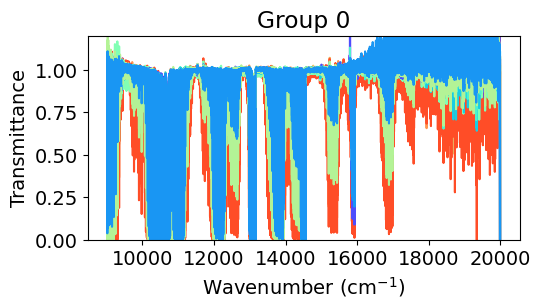

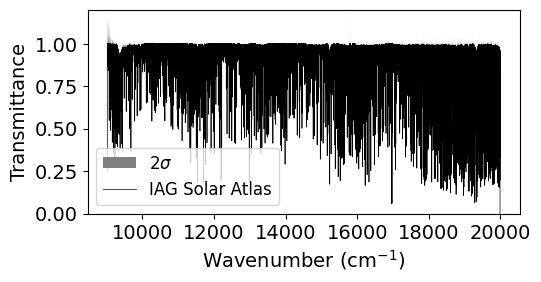

In [ ]:
font = {'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)
cmap = matplotlib.colormaps.get_cmap('rainbow')
plt.ion()

data_path = './data/IAG/' #https://zenodo.org/records/3598136

ot = open_iag(0)  						   # load telluric data for group no. 0 & solar atlas
ot.plot_tel(scale=None)					   # Plot telluric with default color scaling
ot.plot_stel(flag_level=None,plot_tel=False)   # plot stellar atlas, mark points with flag > 1, overlay a mean telluric spectrum


<Axes: title={'center': 'Spectre Tellurique - Groupe 0 (Spec 0)'}, xlabel="Longueur d'onde (nm)">

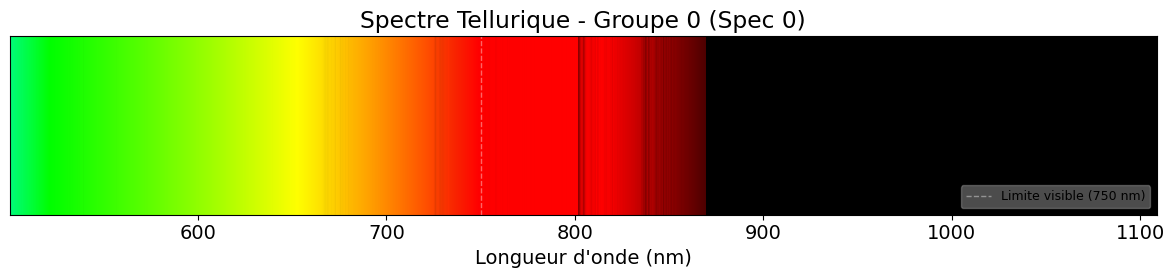

In [33]:
ot.plot_visible_spectrum(index=0,threshold=0.99)